First, let's load the JSON file which describes the human pose task.  This is in COCO format, it is the category descriptor pulled from the annotations file.  We modify the COCO category slightly, to add a neck keypoint.  We will use this task description JSON to create a topology tensor, which is an intermediate data structure that describes the part linkages, as well as which channels in the part affinity field each linkage corresponds to.

In [19]:
import json
import trt_pose.coco

with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)
print(topology.shape)
print(topology)

torch.Size([21, 4])
tensor([[ 0,  1, 15, 13],
        [ 2,  3, 13, 11],
        [ 4,  5, 16, 14],
        [ 6,  7, 14, 12],
        [ 8,  9, 11, 12],
        [10, 11,  5,  7],
        [12, 13,  6,  8],
        [14, 15,  7,  9],
        [16, 17,  8, 10],
        [18, 19,  1,  2],
        [20, 21,  0,  1],
        [22, 23,  0,  2],
        [24, 25,  1,  3],
        [26, 27,  2,  4],
        [28, 29,  3,  5],
        [30, 31,  4,  6],
        [32, 33, 17,  0],
        [34, 35, 17,  5],
        [36, 37, 17,  6],
        [38, 39, 17, 11],
        [40, 41, 17, 12]], dtype=torch.int32)


Next, we'll load our model.  Each model takes at least two parameters, *cmap_channels* and *paf_channels* corresponding to the number of heatmap channels
and part affinity field channels.  The number of part affinity field channels is 2x the number of links, because each link has a channel corresponding to the
x and y direction of the vector field for each link.

In [20]:
import trt_pose.models

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()

Next, let's load the model weights.  You will need to download these according to the table in the README.

In [21]:
import torch

MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'

model.load_state_dict(torch.load(MODEL_WEIGHTS))

<All keys matched successfully>

In order to optimize with TensorRT using the python library *torch2trt* we'll also need to create some example data.  The dimensions
of this data should match the dimensions that the network was trained with.  Since we're using the resnet18 variant that was trained on
an input resolution of 224x224, we set the width and height to these dimensions.

In [22]:
WIDTH = 224
HEIGHT = 224

data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()
data.shape

torch.Size([1, 3, 224, 224])

Next, we'll use [torch2trt](https://github.com/NVIDIA-AI-IOT/torch2trt) to optimize the model.  We'll enable fp16_mode to allow optimizations to use reduced half precision.

In [ ]:
import torch2trt

model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)

The optimized model may be saved so that we do not need to perform optimization again, we can just load the model.  Please note that TensorRT has device specific optimizations, so you can only use an optimized model on similar platforms.

In [ ]:
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

We could then load the saved model using *torch2trt* as follows.

In [ ]:
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

We can benchmark the model in FPS with the following code

In [ ]:
import time

t0 = time.time()
torch.cuda.current_stream().synchronize()
for i in range(50):
    y = model_trt(data)
torch.cuda.current_stream().synchronize()
t1 = time.time()

print(50.0 / (t1 - t0))

Next, let's define a function that will preprocess the image, which is originally in BGR8 / HWC format.

In [23]:
import cv2
import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

Next, we'll define two callable classes that will be used to parse the objects from the neural network, as well as draw the parsed objects on an image.

In [24]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

Assuming you're using NVIDIA Jetson, you can use the [jetcam](https://github.com/NVIDIA-AI-IOT/jetcam) package to create an easy to use camera that will produce images in BGR8/HWC format.

If you're not on Jetson, you may need to adapt the code below.

In [ ]:
from jetcam.usb_camera import USBCamera
# from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg

camera = USBCamera(width=WIDTH, height=HEIGHT, capture_fps=30)
# camera = CSICamera(width=WIDTH, height=HEIGHT, capture_fps=30)

camera.running = True

Next, we'll create a widget which will be used to display the camera feed with visualizations.

In [ ]:
import ipywidgets
from IPython.display import display

image_w = ipywidgets.Image(format='jpeg')

display(image_w)

Finally, we'll define the main execution loop.  This will perform the following steps

1.  Preprocess the camera image
2.  Execute the neural network
3.  Parse the objects from the neural network output
4.  Draw the objects onto the camera image
5.  Convert the image to JPEG format and stream to the display widget

In [ ]:
def execute(change):
    image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

If we call the cell below it will execute the function once on the current camera frame.

In [ ]:
execute({'new': camera.value})

Call the cell below to attach the execution function to the camera's internal value.  This will cause the execute function to be called whenever a new camera frame is received.

In [ ]:
camera.observe(execute, names='value')

Call the cell below to unattach the camera frame callbacks.

In [ ]:
camera.unobserve_all()

### Test w/out TRT
Before we convert the model to trt lets perform a simple test to make sure it is working correctly. And for you to get acquiated with the model.

(224, 224, 3)


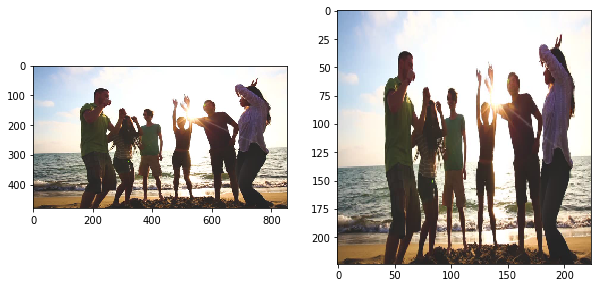

In [25]:
import matplotlib.pyplot as plt
image = plt.imread("people.jpg")
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(image)
fig.add_subplot(1,2,2)
image = cv2.resize(image, (WIDTH,HEIGHT))
plt.imshow(image)
print(image.shape)

In [26]:
img_data = preprocess(image)
print(img_data.shape)
print(img_data)

torch.Size([1, 3, 224, 224])
tensor([[[[ 1.3070,  1.3070,  1.2899,  ...,  1.9920,  1.9920,  2.0434],
          [ 1.3242,  1.3242,  1.3070,  ...,  2.0092,  2.0092,  2.0263],
          [ 1.3413,  1.3413,  1.3242,  ...,  2.0263,  2.0263,  1.9920],
          ...,
          [-1.2103, -1.2445, -1.2959,  ..., -1.4500, -1.4843, -1.4672],
          [-1.4158, -1.4672, -1.4843,  ..., -1.4158, -1.3473, -1.5014],
          [-1.4158, -1.3815, -1.3987,  ..., -1.5699, -1.5528, -1.4158]],

         [[ 0.8004,  0.8004,  0.7829,  ...,  2.2535,  2.2535,  2.2360],
          [ 0.8179,  0.8179,  0.8004,  ...,  2.2535,  2.2535,  2.2535],
          [ 0.8354,  0.8354,  0.8179,  ...,  2.2535,  2.2535,  2.2710],
          ...,
          [-0.4601, -0.4776, -0.5301,  ..., -1.3354, -1.3529, -1.3179],
          [-0.8102, -0.8627, -0.8803,  ..., -1.3529, -1.3704, -1.3704],
          [-0.9328, -0.8803, -0.8978,  ..., -1.3529, -1.3529, -1.3704]],

         [[ 0.4614,  0.4614,  0.4439,  ...,  2.6226,  2.6226,  2.6226],
 

In [27]:
cmap, paf = model(img_data)
cmap, paf = cmap.detach().cpu(), paf.detach().cpu()

In [28]:
print(cmap.shape)
print(paf.shape)

torch.Size([1, 18, 56, 56])
torch.Size([1, 42, 56, 56])


In [29]:
cmap_img = cmap.numpy()[0,:,:,:]
print(cmap_img.shape)
paf_img = paf.numpy()[0,:,:,:]
print(paf_img.shape)

(18, 56, 56)
(42, 56, 56)


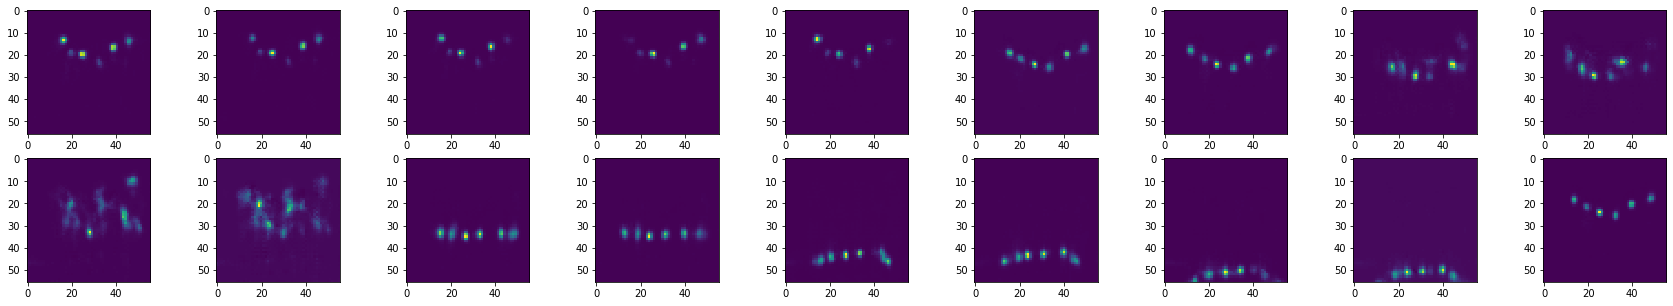

In [30]:
fig = plt.figure(figsize=(30,5))
for i in range(18):
    fig.add_subplot(2,9,i+1)
    plt.imshow(cmap_img[i])

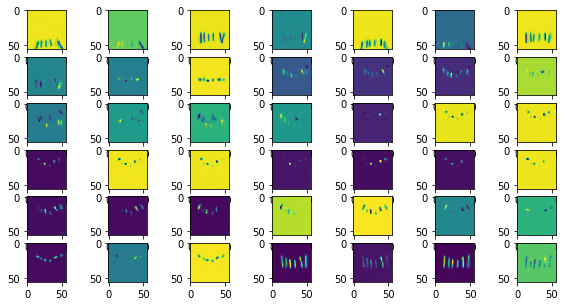

In [31]:
fig = plt.figure(figsize=(10,5))
for i in range(42):
    fig.add_subplot(6,7,i+1)
    plt.imshow(paf_img[i])

0.90179074
-0.028219141
0.46028256


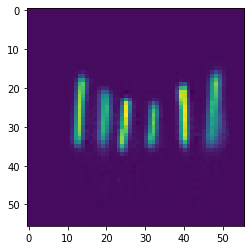

In [94]:
sumed_paf = paf_img[40] + paf_img[41]
plt.imshow(sumed_paf)
print(sumed_paf.max())
print(sumed_paf.min())

print(sumed_paf[30][12])

-0.20465931


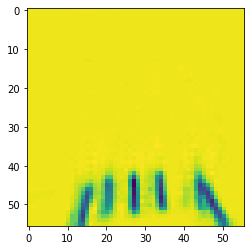

In [105]:
plt.imshow(paf_img[0])
print(paf_img[0][50][33])

-0.027058294


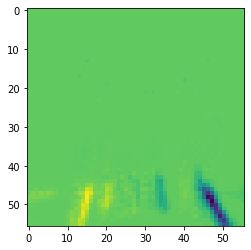

In [106]:
plt.imshow(paf_img[1])
print(paf_img[1][50][33])

In [32]:
counts, objects, peaks = parse_objects(cmap, paf)

In [45]:
print(objects.shape)
print(objects[0][0])
print(peaks.shape)
#print(peaks[0][0])
print(counts.shape)
print(counts.numpy()[0])

torch.Size([1, 100, 18])
tensor([ 0,  0,  0, -1,  0,  1,  0,  1,  0,  1, -1,  0,  0,  3,  4,  4, -1,  0],
       dtype=torch.int32)
torch.Size([1, 18, 100, 2])
torch.Size([1])
9


In [17]:
draw_objects(image, counts, objects, peaks)
print(image.shape)

(224, 224, 3)


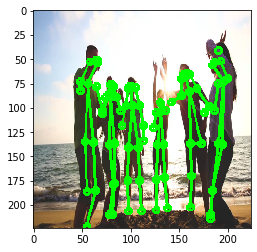

In [18]:
plt.imshow(image)

## Save model as a torch script for use with C++

In [20]:
import torch
# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 224, 224)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model.cpu(), example)

In [21]:
traced_script_module.save("traced_people_trakcer_model.pt")